In [87]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
# Importing the necessary libraries
from sklearn.datasets import load_files 
import keras
from keras.utils import np_utils
import numpy as np
from glob import glob

# Paths of our images
image_login_paths = [(lambda i: i[:-1])(i) for i in open('./Images/Paths/path_login.txt')]
image_non_login_paths = [(lambda i: i[:-1])(i) for i in open('./Images/Paths/path_non_login.txt')]

X = image_login_paths + image_non_login_paths

# Here we provide labels to our images, 1 for login and 0 for non-login images.
y = [1]*len(image_login_paths) + [0]*len(image_non_login_paths)

Using TensorFlow backend.


In [2]:
## Splitting the data into training and testing sets ##
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, shuffle=True, 
                                                    random_state=42)

In [3]:
## Preprocessing the Data ##
from keras.preprocessing import image  
from PIL import Image
import tensorflow as tf
import io

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = Image.open(img_path).convert('LA')
    img = img.resize((800, 600))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [4]:
from PIL import ImageFile                            
# pre-process the data for Keras
train_tensors = paths_to_tensor(X_train).astype('float32')/255
test_tensors = paths_to_tensor(X_test).astype('float32')/255

In [18]:
## Benchmark Model ##
# Model 1
# This model takes into account other details of the page which are not necessary, hence there is an another model prepared.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=4, kernel_size=8, strides=2, padding='valid', activation='relu', input_shape=(600, 800, 2)))
model.add(MaxPooling2D(pool_size=4, padding='same'))
model.add(Conv2D(filters=8, kernel_size=8, strides=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=4, padding='same'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Fitting the model to the training set.
from keras.callbacks import ModelCheckpoint  
model.fit(train_tensors, y_train, epochs=10, batch_size=5, verbose=1)

# Getting the predictions
predictions = [round(float(i), 0) for i in model.predict(test_tensors)]

# Evaluating the performance
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("The accuracy is : {}%".format(round(accuracy*100, 2)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 297, 397, 4)       516       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 75, 100, 4)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 34, 47, 8)         2056      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 9, 12, 8)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 864)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 50)                43250     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 51        
Total para

In [30]:
# Model 2
# This model basically looks for the login, sign up and passwords boxes present in the page which increases the accuracy of our model.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=4, kernel_size=8, strides=2, padding='valid', activation='relu', input_shape=(600, 800, 2)))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=8, kernel_size=8, strides=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=4, padding='same'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Fitting the model to the training set.
from keras.callbacks import ModelCheckpoint  
model.fit(train_tensors, y_train, epochs=10, batch_size=5, verbose=1)

# Getting the predictions
predictions = [round(float(i), 0) for i in model.predict(test_tensors)]

# Evaluating the performance
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("The accuracy is : {}%".format(round(accuracy*100, 2)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 297, 397, 4)       516       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 149, 199, 4)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 71, 96, 8)         2056      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 18, 24, 8)         0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 3456)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 50)                172850    
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 51        
Total para

In [36]:
# Evaluating the performance on Testing set
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("The testing accuracy is : {}%".format(round(accuracy*100, 2)))

The testing accuracy is : 93.1%


In [40]:
# Evaluating the performance on Training set
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, [round(float(i), 0) for i in model.predict(train_tensors)])
print("The training accuracy is : {}%".format(round(accuracy*100, 2)))

The training accuracy is : 100.0%


In [82]:
# Plotting the results that show correct as well as predicted labels for different pages
import matplotlib.pyplot as plt
def show_results(img_path, correct_label, predicted_label):
    label_convert = {0:'non login webpage.', 1:'login webpage.'}
    if correct_label == predicted_label:
        msg="Image is of "+label_convert[correct_label]+" Model predicted it "+label_convert[predicted_label]+" This is correctly predicted by the model."
    else:
        msg="Image is of "+label_convert[correct_label]+" Model predicted it "+label_convert[predicted_label]+" This is incorrectly predicted by the model."
    
    img = Image.open(img_path)
    plt.figure()
    plt.title(msg)
    plt.imshow(np.asarray(img))
    plt.show()
    print('\n\n\n')

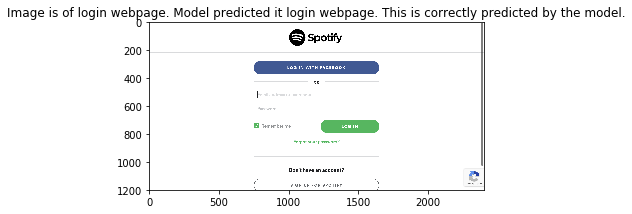

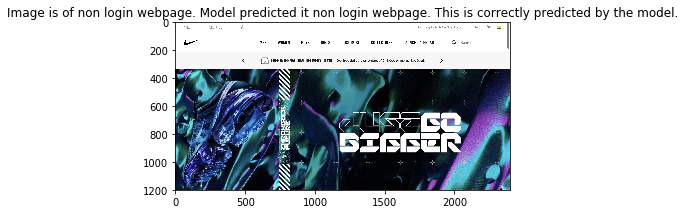

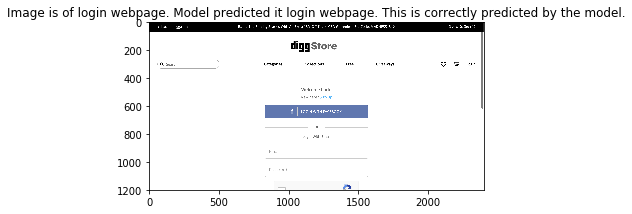

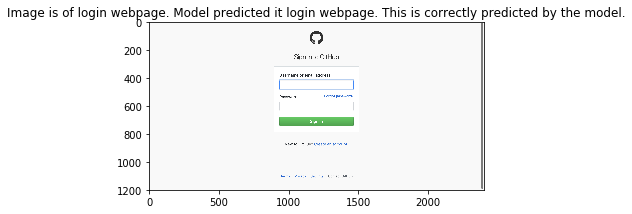

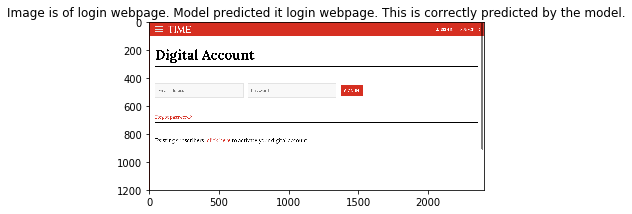

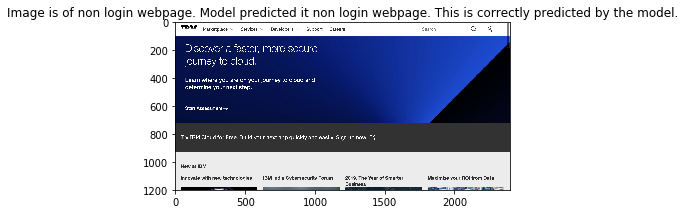

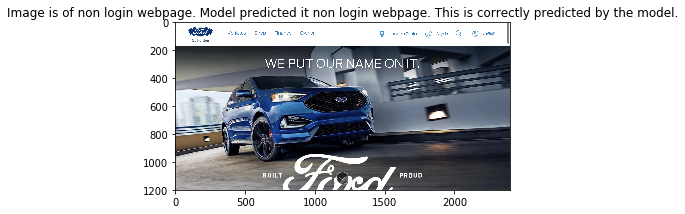

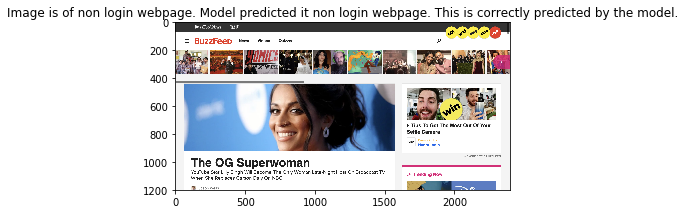

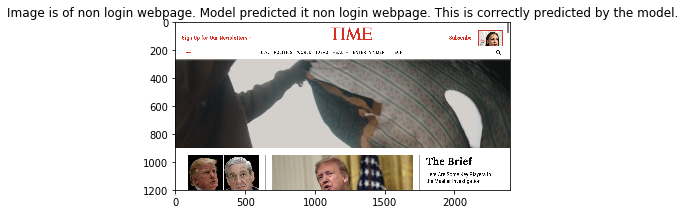

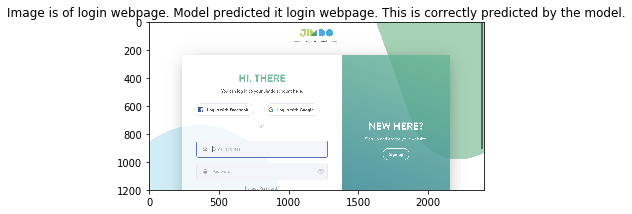

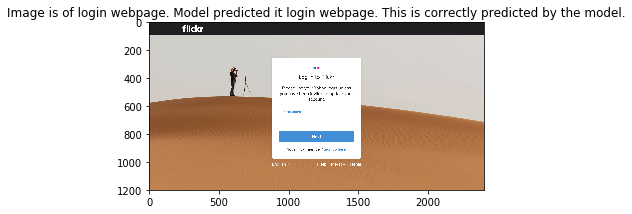

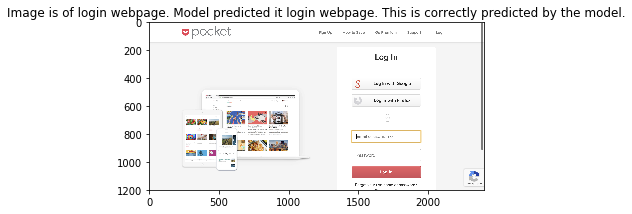

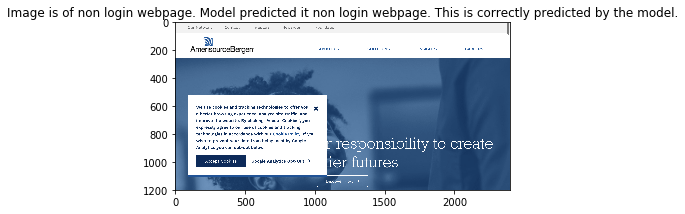

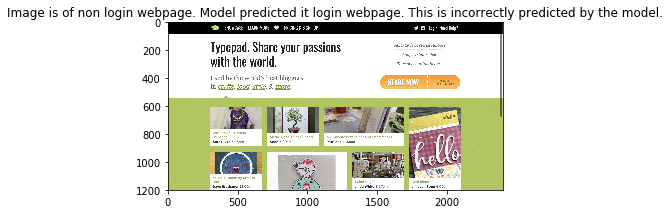

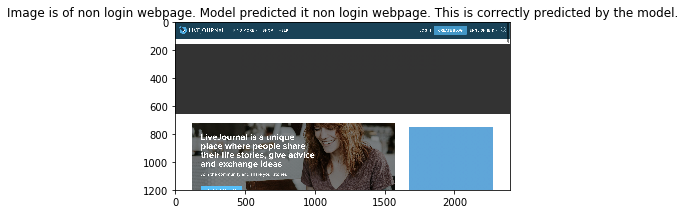

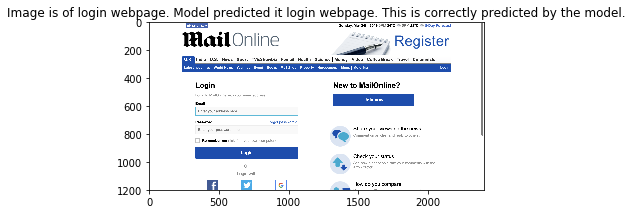

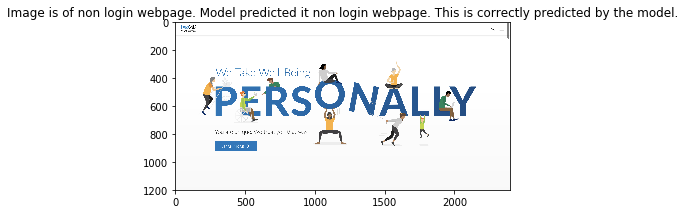

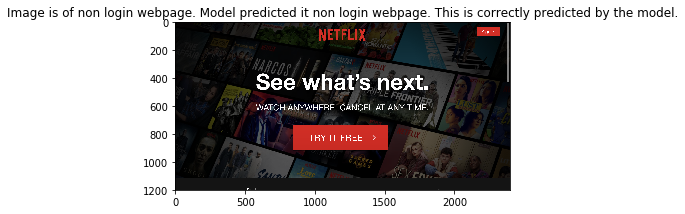

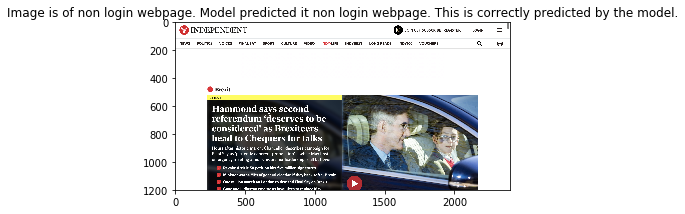

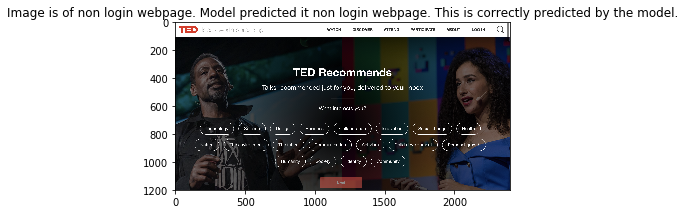

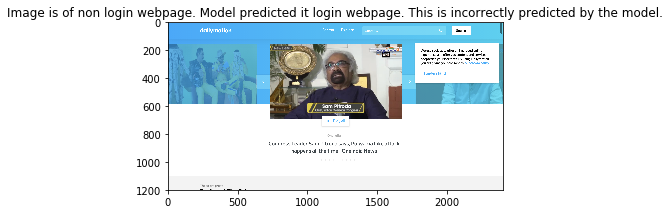

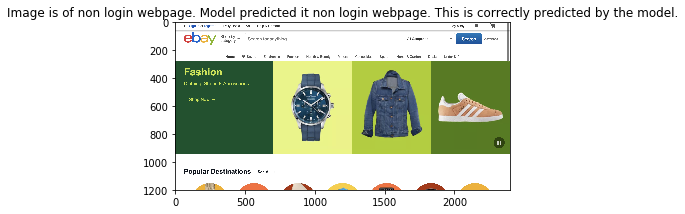

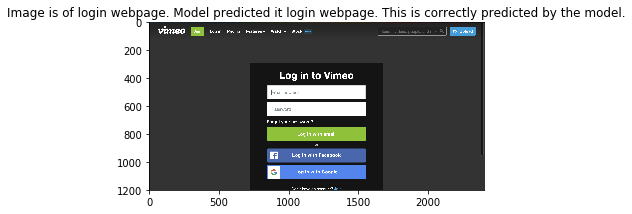

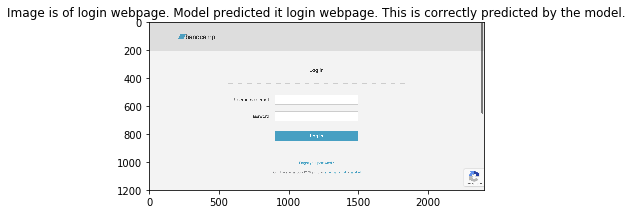

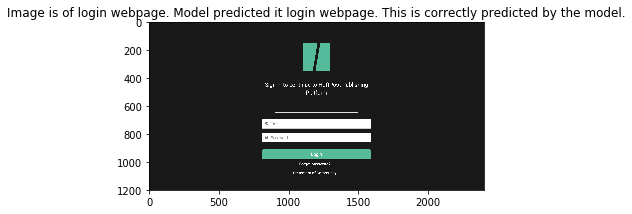

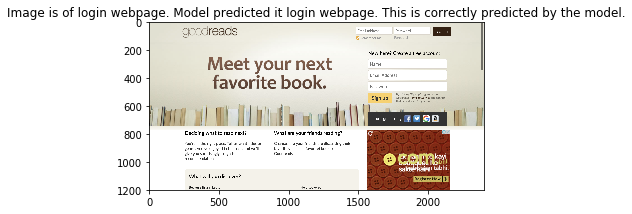

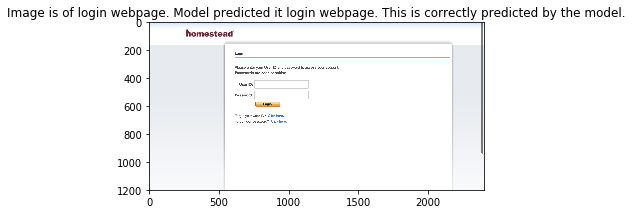

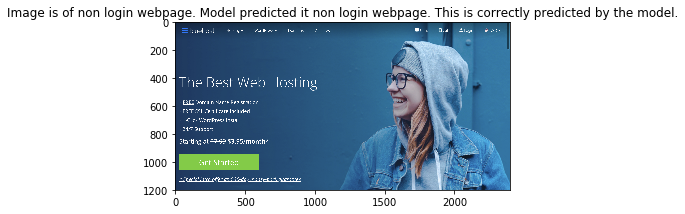

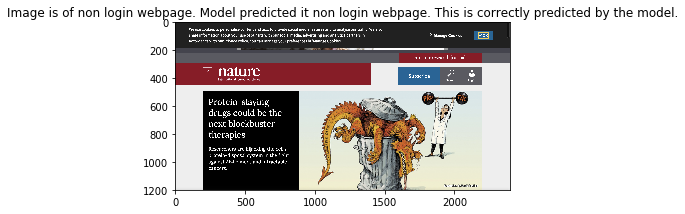

In [88]:
for i, path in enumerate(X_test):
    show_results(path, y_test[i], predictions[i])

Out of 29 test images, the model correctly classified 28 of them. This is a very good model giving robust and consistent results.